In [1]:
#model_checkpoint = "t5-base"
# model_checkpoint = "unicamp-dl/ptt5-base-t5-vocab"
model_checkpoint = 'QA-ptt5-base-without-retrieval/checkpoint-9000'
#model_checkpoint = "facebook/bart-base"
#model_checkpoint = "unicamp-dl/ptt5-base-t5-vocab"
#model_checkpoint = 'neuralmind/bert-base-portuguese-cased'

In [2]:
import pandas as pd

PATH_QUESTION = 'finetune_qa_pairs_14k/'

max_input_length = 512
max_target_length = 32
test_source = pd.read_csv(PATH_QUESTION + 'test.source', sep = "\t", header = None).values.tolist()  

test_target = pd.read_csv(PATH_QUESTION + 'test.target', sep = "\t", header = None).values.tolist()   


In [3]:
import pandas as pd
import ast

def preprocess(source, target):
    questions = []
    answer = []
    for i in range(len(source)):
        questions.append( "question: " + source[i][0])
        answer.append(target[i][0])

    pd_dataset = pd.DataFrame({'question': questions, 'answer' : answer})
    pd_dataset.head()
    
    return(pd_dataset)


pd_dataset_test = preprocess(test_source, test_target)


In [4]:
from datasets import load_dataset, load_metric, DatasetDict, Dataset


dataset_test = Dataset.from_pandas(df=pd_dataset_test)


raw_datasets = DatasetDict({
    'test': dataset_test})
metric = load_metric("rouge")

In [5]:
from transformers import AutoTokenizer, T5Tokenizer, T5TokenizerFast, TFT5Model, TFT5ForConditionalGeneration

#tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer = T5Tokenizer.from_pretrained(model_checkpoint)


In [6]:


def preprocess_input(examples):
    model_inputs = tokenizer(examples["question"], max_length=max_input_length, truncation=True)
    return model_inputs

def preprocess_function(examples):
    model_inputs = preprocess_input(examples)
    # Setup the tokenizer for targets
    labels = tokenizer(examples["answer"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [7]:
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)


  0%|          | 0/1 [00:00<?, ?ba/s]

In [8]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [9]:
batch_size = 4
args = Seq2SeqTrainingArguments(
    "test-model",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=30,
    predict_with_generate=True,
    fp16=True,
    gradient_accumulation_steps = 4
)

In [10]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [11]:
import nltk
#nltk.download('punkt')
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

In [12]:
trainer = Seq2SeqTrainer(
    model,
    args,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [13]:
a = trainer.predict(tokenized_datasets['test'], max_length=max_target_length)

/home/blab-answerer/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:65: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [14]:
test_outputs = []
test_labels = []
for i in range(len(a.predictions)):
    test_outputs.append(tokenizer.decode(a.predictions[i], skip_special_tokens=True))
    test_labels.append(raw_datasets['test'][i]['answer'])
pd_output = pd.DataFrame({'predicted' : test_outputs, 'label' : test_labels})

In [15]:
from rouge_score import rouge_scorer
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import SmoothingFunction
from nltk.metrics import f_measure
import nltk
import string
import re
import collections

def get_tokens(sentence):
    tokens = word_tokenize(sentence)
    return tokens

def normalize_text(sentence):

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()
    return white_space_fix(remove_punc(lower(sentence)))

def f1_score_qa(text_true,text_pred):
    "squad"
    text_true = normalize_text(text_true)
    text_pred = normalize_text(text_pred)
    true_tokens = get_tokens(text_true)
    pred_tokens = get_tokens(text_pred)
    common = collections.Counter(true_tokens) & collections.Counter(pred_tokens)
    num_same = sum(common.values())
    if len(true_tokens) == 0 or len(pred_tokens) == 0:
        return int(true_tokens==pred_tokens),int(true_tokens==pred_tokens),int(true_tokens==pred_tokens)
    if num_same == 0:
        return 0,0,0
    precision = 1 * num_same / len(pred_tokens)
    recall = 1 * num_same / len(true_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1, precision, recall

def em_qa(text_true,text_pred):
    return int(normalize_text(text_true) == normalize_text(text_pred))

def rouge_l_qa(text_true,text_pred):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    scores = scorer.score(text_true,text_pred)

    return scores["rougeL"].fmeasure

def em_qa_overall(text_true,text_pred):
    scores = 0
    for i in range(len(text_true)):
        scores += em_qa(text_true[i],text_pred[i])
    score = scores/len(text_true)
    return score

def f1_score_qa_overall(text_true,text_pred):
    f = 0
    for i in range(len(text_true)):
        fi,pi,ri = f1_score_qa(text_true[i],text_pred[i])
        f+=fi
    f = f/len(text_true)
    return f

def rouge_l_qa_overall(text_true,text_pred):
    scores = 0
    for i in range(len(text_true)):
        score = rouge_l_qa(text_true[i],text_pred[i])
        scores += score
    scores = scores/len(text_true)
    return scores

def scores(func,text_true,text_pred):
    if func=='rouge_l_qa':
        score_value = rouge_l_qa(text_true,text_pred)
    if func=='em_qa':
        score_value = em_qa(text_true,text_pred)
    if func=='f1_score_qa':
        score_value = f1_score_qa(text_true,text_pred)
    return (func, score_value)
        

def overall(func,text_true,text_pred):
    if func=='rouge_l_qa_overall':
        score_value = rouge_l_qa_overall(text_true,text_pred)
    if func=='em_qa_overall':
        score_value = em_qa_overall(text_true,text_pred)
    if func=='f1_score_qa_overall':
        score_value = f1_score_qa_overall(text_true,text_pred)
    return (func, score_value)

In [16]:
print("f1-score: " + str(overall("f1_score_qa_overall", test_labels, test_outputs)))
print("EM: " + str(overall('em_qa_overall', test_labels, test_outputs)))
print("Rouge-L: " + str(overall('rouge_l_qa_overall', test_labels, test_outputs)))

f1-score: ('f1_score_qa_overall', 0.0)
EM: ('em_qa_overall', 0.0)
Rouge-L: ('rouge_l_qa_overall', 0.0)


In [17]:
questions = []
for i in range(len(test_source)):
    questions.append(test_source[i][0])
questions[0:3]

['Qual foi o recorde de queimadas na Floresta Amazônica',
 'Qual foi o posicionamento do Brasil na Cúpula do Clima de 2021',
 'Quais foram as causas dos incêndios no Pantanal em 2020']

In [18]:
df = pd.DataFrame({'question':questions, 'answer': test_labels, 'gen_answer': test_outputs})
print(len(df))
df.head()

7


,question,answer,gen_answer
0,Qual foi o recorde de queimadas na Floresta Am...,,Mais de 3 milhões de hectares
1,Qual foi o posicionamento do Brasil na Cúpula ...,,o clima global
2,Quais foram as causas dos incêndios no Pantana...,,Desmatamento
3,Quando ocorreu o recorde de incêndios floresta...,,2010.
4,Onça pintada está ameaçada de extinção,,Mata Atlântica


In [19]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.0)

In [20]:
model_name = model_checkpoint
for _, row in tqdm(df.iterrows()):
    # F1-score
    _, f1_score = scores('f1_score_qa', row['gen_answer'], row['answer'])
    df.loc[df['question']==row['question'], '{}_f1'.format(model_name)] = round(f1_score[0], 2)

    # Rouge
    _, rouge_l = scores('rouge_l_qa', row['gen_answer'], row['answer'])
    rouge_l_f = rouge_l
    df.loc[df['question']==row['question'], '{}_rouge_l_f'.format(model_name)] = round(rouge_l_f, 2)

    # Exact Match
    _, em = scores('em_qa', row['gen_answer'], row['answer'])
    df.loc[df['question']==row['question'], '{}_em'.format(model_name)] = round(em, 2)
    
filename = 'TEST_RESULTS_{}_{}.csv'.format(model_name.split('/')[0], model_name.split('/')[1])
df.to_csv(filename, index=False)

7it [00:00, 623.87it/s]


In [21]:
df.head()

,question,answer,gen_answer,QA-ptt5-base-without-retrieval/checkpoint-9000_f1,QA-ptt5-base-without-retrieval/checkpoint-9000_rouge_l_f,QA-ptt5-base-without-retrieval/checkpoint-9000_em
0,Qual foi o recorde de queimadas na Floresta Am...,,Mais de 3 milhões de hectares,0.0,0.0,0.0
1,Qual foi o posicionamento do Brasil na Cúpula ...,,o clima global,0.0,0.0,0.0
2,Quais foram as causas dos incêndios no Pantana...,,Desmatamento,0.0,0.0,0.0
3,Quando ocorreu o recorde de incêndios floresta...,,2010.,0.0,0.0,0.0
4,Onça pintada está ameaçada de extinção,,Mata Atlântica,0.0,0.0,0.0


In [22]:
sns.set(font_scale=1.0)

In [23]:
df.describe()

,QA-ptt5-base-without-retrieval/checkpoint-9000_f1,QA-ptt5-base-without-retrieval/checkpoint-9000_rouge_l_f,QA-ptt5-base-without-retrieval/checkpoint-9000_em
count,7.0,7.0,7.0
mean,0.0,0.0,0.0
std,0.0,0.0,0.0
min,0.0,0.0,0.0
25%,0.0,0.0,0.0
50%,0.0,0.0,0.0
75%,0.0,0.0,0.0
max,0.0,0.0,0.0


<Figure size 7200x2160 with 0 Axes>

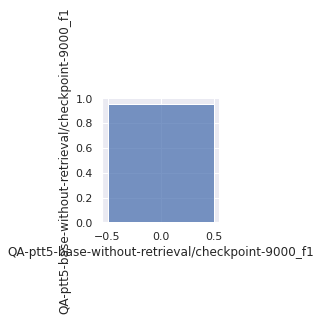

<Figure size 7200x2160 with 0 Axes>

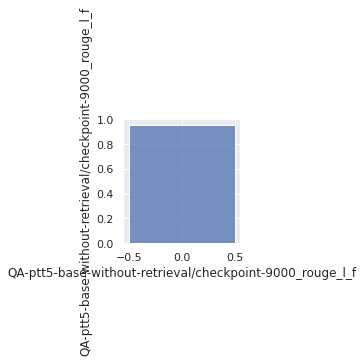

<Figure size 7200x2160 with 0 Axes>

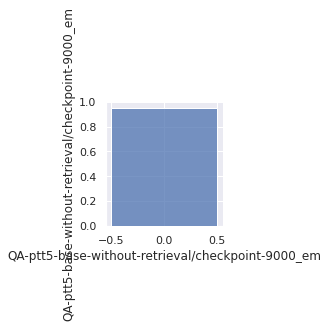

In [24]:
metrics = ['f1', 'rouge', 'em']
for metric in metrics:    
    plt.figure(figsize=(100, 30))

    sns.pairplot(df.filter(like=metric), diag_kind='hist', height=2.5)
    plt.show()